# 0 - Importing Packages and Dataframe

## 0.1 - Import Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
import nltk
import kaggle
import re
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
import string

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\I43282N\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 0.2 - Import Dataset

In [34]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download the dataset
api.dataset_download_files('crowdflower/twitter-airline-sentiment', path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment


## 0.3 - Print DataFrame

In [35]:
df_tweets = pd.read_csv('Tweets.csv')

In [36]:
df_tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# 1.0 - Data Manipulation

## 1.1 - Data Normalization (Convert to lowercase)

In [37]:
# Convert the text to Lowercase
df_text_lower = df_tweets.copy()
df_text_lower['text_lower'] = df_text_lower['text'].str.lower()

In [38]:
# Visualize the Result
df_text_lower[['text_lower', 'text']].head()

,text_lower,text
0,@virginamerica what @dhepburn said.,@VirginAmerica What @dhepburn said.
1,@virginamerica plus you've added commercials t...,@VirginAmerica plus you've added commercials t...
2,@virginamerica i didn't today... must mean i n...,@VirginAmerica I didn't today... Must mean I n...
3,@virginamerica it's really aggressive to blast...,@VirginAmerica it's really aggressive to blast...
4,@virginamerica and it's a really big bad thing...,@VirginAmerica and it's a really big bad thing...


## 1.2 - Remove URLs

In [39]:
# Remove URLs from text
df_no_urls = df_text_lower.copy()
df_no_urls['text_no_urls'] = df_no_urls['text_lower'].apply(lambda x: re.sub(r'http\S+|www\S+', '', x))

In [40]:
# Visualize the result
df_no_urls[['text_lower', 'text_no_urls']].head()

,text_lower,text_no_urls
0,@virginamerica what @dhepburn said.,@virginamerica what @dhepburn said.
1,@virginamerica plus you've added commercials t...,@virginamerica plus you've added commercials t...
2,@virginamerica i didn't today... must mean i n...,@virginamerica i didn't today... must mean i n...
3,@virginamerica it's really aggressive to blast...,@virginamerica it's really aggressive to blast...
4,@virginamerica and it's a really big bad thing...,@virginamerica and it's a really big bad thing...


## 1.3 - Remove Mentioned Users (@users)

In [41]:
# Remove mentions from text
df_no_mentions = df_no_urls.copy()
df_no_mentions['text_no_mentions'] = df_no_mentions['text_no_urls'].apply(lambda x: re.sub(r'@\w+', '', x))

In [42]:
# Visualize the result
df_no_mentions[['text_no_urls', 'text_no_mentions']].head()

,text_no_urls,text_no_mentions
0,@virginamerica what @dhepburn said.,what said.
1,@virginamerica plus you've added commercials t...,plus you've added commercials to the experien...
2,@virginamerica i didn't today... must mean i n...,i didn't today... must mean i need to take an...
3,@virginamerica it's really aggressive to blast...,"it's really aggressive to blast obnoxious ""en..."
4,@virginamerica and it's a really big bad thing...,and it's a really big bad thing about it


## 1.4 - Remove Hashtags and Punctuation

In [43]:
# Remove hashtags and punctuation
df_no_hashtag_punct = df_no_mentions.copy()
df_no_hashtag_punct['text_no_hashtags_punct'] = df_no_hashtag_punct['text_no_mentions'].apply(lambda x: re.sub(r'#\w+', '', x)).apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [44]:
# Visualize the result
df_no_hashtag_punct[['text_no_urls', 'text_no_hashtags_punct']].head()

,text_no_urls,text_no_hashtags_punct
0,@virginamerica what @dhepburn said.,what said
1,@virginamerica plus you've added commercials t...,plus youve added commercials to the experienc...
2,@virginamerica i didn't today... must mean i n...,i didnt today must mean i need to take anothe...
3,@virginamerica it's really aggressive to blast...,its really aggressive to blast obnoxious ente...
4,@virginamerica and it's a really big bad thing...,and its a really big bad thing about it


## 1.5 - Remove Numbers and Stopwords

In [45]:
stop_words = set(stopwords.words('english'))

# Remove numbers and stopwords
df_no_stopwords = df_no_hashtag_punct.copy()
df_no_stopwords['clean_text'] = df_no_stopwords['text_no_hashtags_punct'].apply(
    lambda x: re.sub(r'\d+', '', x) # Remove numbers
).apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words]) # Remove stopwords
)

In [46]:
# Visualize the result
df_no_stopwords[['text_no_hashtags_punct', 'clean_text']].head()

,text_no_hashtags_punct,clean_text
0,what said,said
1,plus youve added commercials to the experienc...,plus youve added commercials experience tacky
2,i didnt today must mean i need to take anothe...,didnt today must mean need take another trip
3,its really aggressive to blast obnoxious ente...,really aggressive blast obnoxious entertainmen...
4,and its a really big bad thing about it,really big bad thing


# 2.0 - Vectorize the text 'clean_text'

In [47]:
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Apply TF-IDF to the 'clean_text' column
X = vectorizer.fit_transform(df_no_stopwords['clean_text'])

# Visualize the shape of the matrix
X.shape

(14640, 11071)

# 3.0 - Define the Data Split

In [48]:
# Define the labels
y = df_no_stopwords['airline_sentiment']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Check the size of the training and test sets
print(f"Training:" , X_train.shape)
print(f"Testing:", X_test.shape)

Training: (11712, 11071)
Testing: (2928, 11071)


# 4.0 - Train and Classify the Model

In [49]:
model = MultinomialNB()
model.fit(X_train, y_train)

print("Model fitted successfully!")

Model fitted successfully!


# 5.0 - Evaluate the Model

In [50]:
y_pred = model.predict(X_test)


✅ Accuracy: 0.71


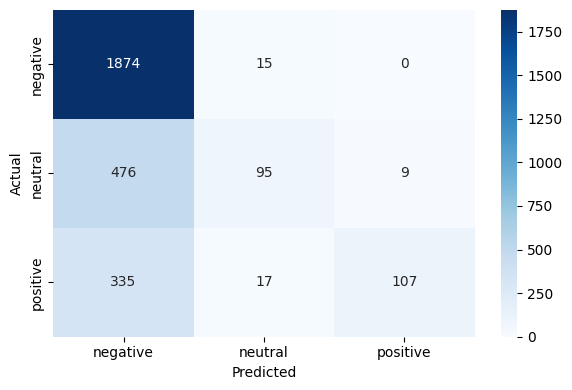


📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.70      0.99      0.82      1889
     neutral       0.75      0.16      0.27       580
    positive       0.92      0.23      0.37       459

    accuracy                           0.71      2928
   macro avg       0.79      0.46      0.49      2928
weighted avg       0.74      0.71      0.64      2928



In [51]:
# Make predictions with test data
accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {accuracy:.2f}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_ if hasattr(model, "classes_") else sorted(set(y_test)),
            yticklabels=model.classes_ if hasattr(model, "classes_") else sorted(set(y_test)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))


In [52]:
# Check the class distribution
print("Class distribution:")
print(df_no_stopwords['airline_sentiment'].value_counts())
print("\nClass proportions:")
print(df_no_stopwords['airline_sentiment'].value_counts(normalize=True))

Class distribution:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Class proportions:
negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64


# 6.0 - Improving the Accuracy

## 6.1 - TF-IDF Improved with N-grams

In [53]:
# New Vectorization with Adjusted Parameters
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Unigrams and bigrams
    max_df=0.9,          # Ignore terms that appear in more than 90% of the documents
    min_df=5,            # Ignore terms that appear in less than 5 documents
    stop_words='english' # Remove English stop words
)

# Apply the new vectorization
X = vectorizer.fit_transform(df_no_stopwords['clean_text'])

# Split the data again
y = df_no_stopwords['airline_sentiment']

In [54]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training: ", X_train.shape)
print(f"Testing: ", X_test.shape)

Training:  (11712, 3925)
Testing:  (2928, 3925)


# 7.0 - Analysis of Class Distribution

=== CLASS DISTRIBUTION ANALYSIS ===

📊 Absolute class distribution:
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

📊 Percentage class distribution:
negative: 62.69%
neutral: 21.17%
positive: 16.14%


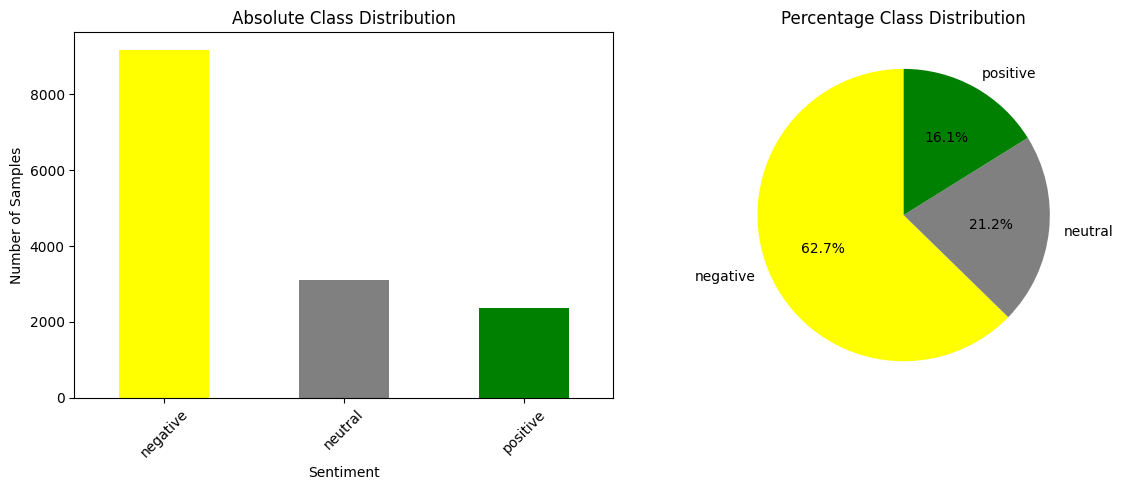


⚖️ Imbalance ratio: 3.88
⚠️ Dataset is IMBALANCED! Balancing techniques will be necessary.


In [55]:
# Analyze the distribution of classes
print("=== CLASS DISTRIBUTION ANALYSIS ===\n")

# Count the classes
class_counts = y.value_counts()
class_proportions = y.value_counts(normalize=True)

print("📊 Absolute class distribution:")
print(class_counts)
print(f"\n📊 Percentage class distribution:")
for sentiment, proportion in class_proportions.items():
    print(f"{sentiment}: {proportion:.2%}")

# Visualize the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
class_counts.plot(kind='bar', ax=ax1, color=['yellow', 'gray', 'green'])
ax1.set_title('Absolute Class Distribution')
ax1.set_ylabel('Number of Samples')
ax1.set_xlabel('Sentiment')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', 
        colors=['yellow', 'gray', 'green'], startangle=90)
ax2.set_title('Percentage Class Distribution')

plt.tight_layout()
plt.show()

# Calculate the degree of imbalance
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class

print(f"\n⚖️ Imbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 1.5:
    print("⚠️ Dataset is IMBALANCED! Balancing techniques will be necessary.")
else:
    print("✅ Dataset is relatively BALANCED.")

## 7.1 - Class Balancing

=== APPLYING BALANCING TECHNIQUES ===

📊 Original distribution in training set:
Counter({'negative': 7343, 'neutral': 2479, 'positive': 1890})

🔄 Applying SMOTE...
📊 Distribution after SMOTE:
Counter({'neutral': 7343, 'negative': 7343, 'positive': 7343})

🔄 Applying Random Under Sampling...
📊 Distribution after Under Sampling:
Counter({'negative': 1890, 'neutral': 1890, 'positive': 1890})

🔄 Applying SMOTEENN...
📊 Distribution after SMOTE:
Counter({'neutral': 7343, 'negative': 7343, 'positive': 7343})

🔄 Applying Random Under Sampling...
📊 Distribution after Under Sampling:
Counter({'negative': 1890, 'neutral': 1890, 'positive': 1890})

🔄 Applying SMOTEENN...
📊 Distribution after SMOTEENN:
Counter({'positive': 5694, 'neutral': 4746, 'negative': 162})
📊 Distribution after SMOTEENN:
Counter({'positive': 5694, 'neutral': 4746, 'negative': 162})


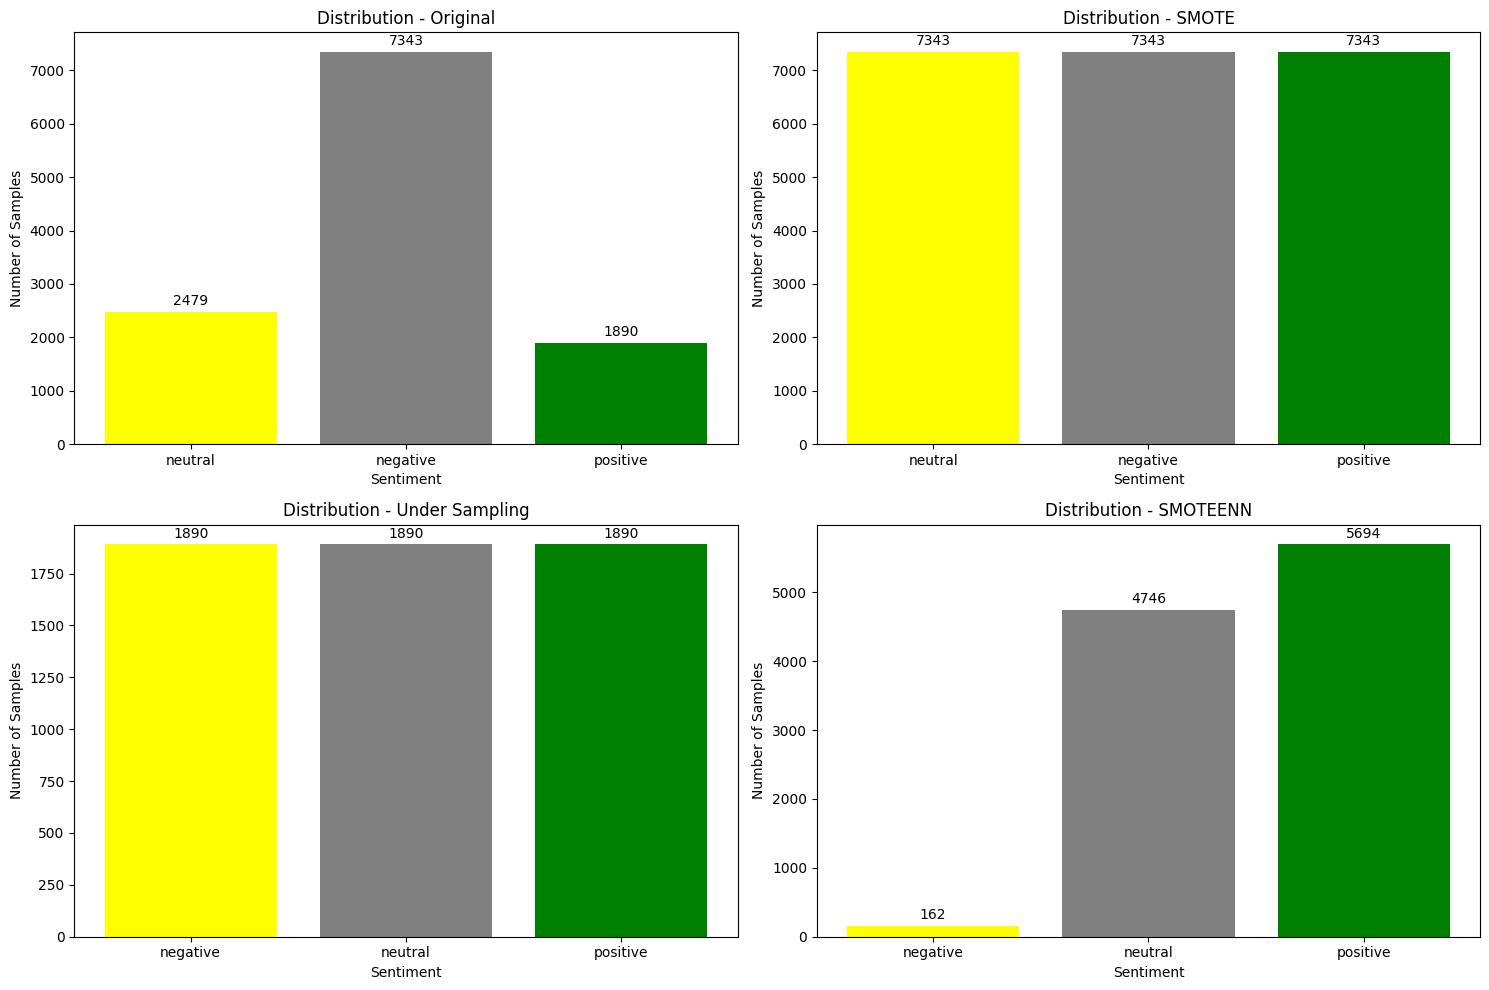

In [56]:
print("=== APPLYING BALANCING TECHNIQUES ===\n")

# First, let's split the original (unbalanced) data
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("📊 Original distribution in training set:")
print(Counter(y_train_orig))

# Technique 1: SMOTE (Synthetic Minority Oversampling Technique)
print("\n🔄 Applying SMOTE...")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_orig, y_train_orig)

print("📊 Distribution after SMOTE:")
print(Counter(y_train_smote))

# Technique 2: Random Under Sampling
print("\n🔄 Applying Random Under Sampling...")
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_orig, y_train_orig)

print("📊 Distribution after Under Sampling:")
print(Counter(y_train_under))

# Technique 3: SMOTEENN (combination of over and under sampling)
print("\n🔄 Applying SMOTEENN...")
smoteenn = SMOTEENN(random_state=42)
X_train_combined, y_train_combined = smoteenn.fit_resample(X_train_orig, y_train_orig)

print("📊 Distribution after SMOTEENN:")
print(Counter(y_train_combined))

# Visualize the distributions
techniques = ['Original', 'SMOTE', 'Under Sampling', 'SMOTEENN']
datasets = [
    Counter(y_train_orig),
    Counter(y_train_smote), 
    Counter(y_train_under),
    Counter(y_train_combined)
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, (technique, data) in enumerate(zip(techniques, datasets)):
    sentiments = list(data.keys())
    counts = list(data.values())
    
    axes[i].bar(sentiments, counts, color=['yellow', 'gray', 'green'])
    axes[i].set_title(f'Distribution - {technique}')
    axes[i].set_ylabel('Number of Samples')
    axes[i].set_xlabel('Sentiment')
    
    # Add values to the bars
    for j, v in enumerate(counts):
        axes[i].text(j, v + max(counts)*0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 7.2 - Model Comparison with Balanced Data

=== MODEL COMPARISON WITH BALANCED DATA ===


🔍 Testing with dataset: Original
--------------------------------------------------
  Naive Bayes          | Acc: 0.733 | F1: 0.694 | Prec: 0.730 | Rec: 0.733
  Logistic Regression  | Acc: 0.762 | F1: 0.744 | Prec: 0.751 | Rec: 0.762
  SVM                  | Acc: 0.761 | F1: 0.757 | Prec: 0.757 | Rec: 0.761

🔍 Testing with dataset: SMOTE
--------------------------------------------------
  Logistic Regression  | Acc: 0.762 | F1: 0.744 | Prec: 0.751 | Rec: 0.762
  SVM                  | Acc: 0.761 | F1: 0.757 | Prec: 0.757 | Rec: 0.761

🔍 Testing with dataset: SMOTE
--------------------------------------------------
  Naive Bayes          | Acc: 0.731 | F1: 0.736 | Prec: 0.744 | Rec: 0.731
  Naive Bayes          | Acc: 0.731 | F1: 0.736 | Prec: 0.744 | Rec: 0.731
  Logistic Regression  | Acc: 0.744 | F1: 0.751 | Prec: 0.763 | Rec: 0.744
  Logistic Regression  | Acc: 0.744 | F1: 0.751 | Prec: 0.763 | Rec: 0.744
  SVM                  | Acc: 0

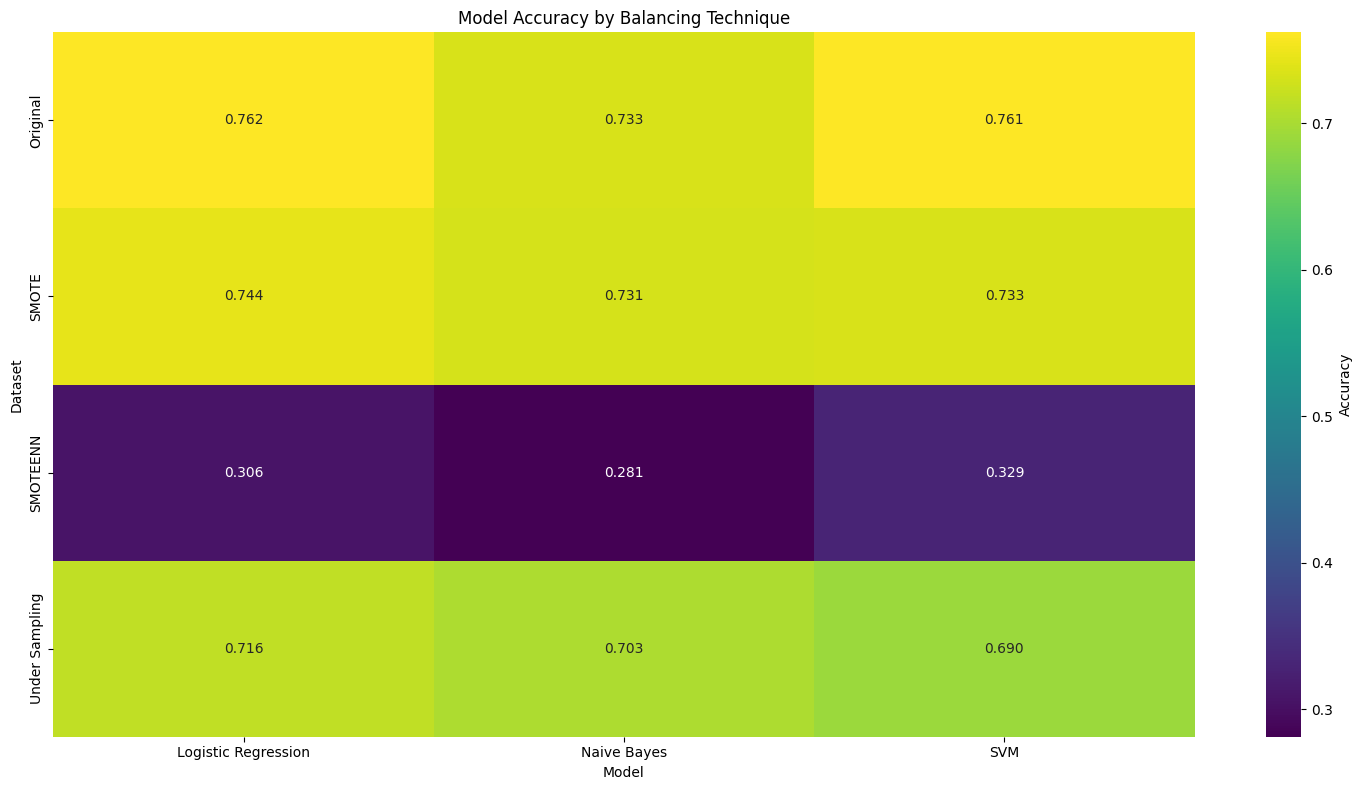


📊 COMPLETE RESULTS TABLE:
           Dataset                Model  Accuracy  F1-Score  Precision  Recall
0         Original          Naive Bayes     0.733     0.694      0.730   0.733
1         Original  Logistic Regression     0.762     0.744      0.751   0.762
2         Original                  SVM     0.761     0.757      0.757   0.761
3            SMOTE          Naive Bayes     0.731     0.736      0.744   0.731
4            SMOTE  Logistic Regression     0.744     0.751      0.763   0.744
5            SMOTE                  SVM     0.733     0.738      0.747   0.733
6   Under Sampling          Naive Bayes     0.703     0.712      0.735   0.703
7   Under Sampling  Logistic Regression     0.716     0.728      0.759   0.716
8   Under Sampling                  SVM     0.690     0.704      0.742   0.690
9         SMOTEENN          Naive Bayes     0.281     0.154      0.731   0.281
10        SMOTEENN  Logistic Regression     0.306     0.183      0.720   0.306
11        SMOTEENN       

In [57]:
# Compare the performance of the models with different balancing techniques
from sklearn.metrics import f1_score, precision_score, recall_score

# Define the models to be tested
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM": LinearSVC(max_iter=2000)
}

# Define the balanced datasets
balanced_datasets = {
    "Original": (X_train_orig, y_train_orig),
    "SMOTE": (X_train_smote, y_train_smote),
    "Under Sampling": (X_train_under, y_train_under),
    "SMOTEENN": (X_train_combined, y_train_combined)
}

# Store results
results = []

print("=== MODEL COMPARISON WITH BALANCED DATA ===\n")

for dataset_name, (X_train_balanced, y_train_balanced) in balanced_datasets.items():
    print(f"\n🔍 Testing with dataset: {dataset_name}")
    print("-" * 50)
    
    for model_name, model in models.items():
        # Train the model
        model.fit(X_train_balanced, y_train_balanced)
        
        # Make predictions (always on the same test set)
        y_pred = model.predict(X_test_orig)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test_orig, y_pred)
        f1 = f1_score(y_test_orig, y_pred, average='weighted')
        precision = precision_score(y_test_orig, y_pred, average='weighted')
        recall = recall_score(y_test_orig, y_pred, average='weighted')
        
        # Store results

        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Precision': precision,
            'Recall': recall
        })
        
        print(f"  {model_name:20} | Acc: {accuracy:.3f} | F1: {f1:.3f} | Prec: {precision:.3f} | Rec: {recall:.3f}")

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Find the best model
best_result = results_df.loc[results_df['Accuracy'].idxmax()]
print(f"\n🏆 BEST RESULT:")
print(f"Dataset: {best_result['Dataset']}")
print(f"Model: {best_result['Model']}")
print(f"Accuracy: {best_result['Accuracy']:.3f}")
print(f"F1-Score: {best_result['F1-Score']:.3f}")

# Visualize the results
plt.figure(figsize=(15, 8))

# Accuracy chart by dataset and model
pivot_acc = results_df.pivot(index='Dataset', columns='Model', values='Accuracy')
sns.heatmap(pivot_acc, annot=True, fmt='.3f', cmap='viridis', cbar_kws={'label': 'Accuracy'})
plt.title('Model Accuracy by Balancing Technique')
plt.tight_layout()
plt.show()

# Show complete results table
print("\n📊 COMPLETE RESULTS TABLE:")
print(results_df.round(3))

# 8.0 - Recommendations and Conclusions

=== TRAINING THE BEST MODEL ===

🏆 Best combination: Logistic Regression with Original

✅ FINAL RESULT:
   Accuracy: 0.762
   F1-Score: 0.744

✅ FINAL RESULT:
   Accuracy: 0.762
   F1-Score: 0.744


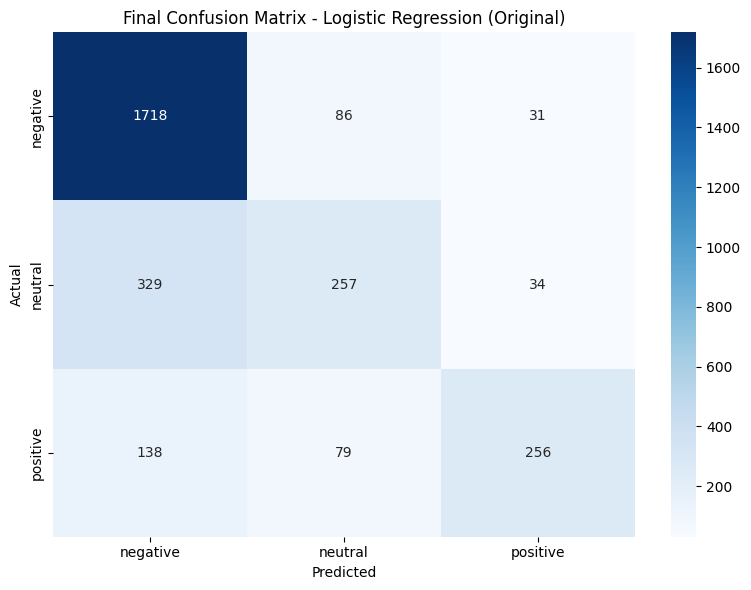


📋 Final Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.94      0.85      1835
     neutral       0.61      0.41      0.49       620
    positive       0.80      0.54      0.64       473

    accuracy                           0.76      2928
   macro avg       0.73      0.63      0.66      2928
weighted avg       0.75      0.76      0.74      2928


💡 RECOMMENDATIONS:
   1. Use the Logistic Regression model trained with Original data
   2. Accuracy improved to 0.762
   3. Class balancing was crucial for improving performance
   4. Continue monitoring metrics on new data


In [58]:
# Train the best model found
print("=== TRAINING THE BEST MODEL ===\n")

# Use the best parameters found in the analysis
best_dataset_name = best_result['Dataset']
best_model_name = best_result['Model']

print(f"🏆 Best combination: {best_model_name} with {best_dataset_name}")

# Select the corresponding dataset and model
best_X_train, best_y_train = balanced_datasets[best_dataset_name]

if best_model_name == "Naive Bayes":
    final_model = MultinomialNB()
elif best_model_name == "Logistic Regression":
    final_model = LogisticRegression(max_iter=2000)
else:  # SVM
    final_model = LinearSVC(max_iter=2000)

# Train the final model
final_model.fit(best_X_train, best_y_train)
final_predictions = final_model.predict(X_test_orig)

# Final evaluation
final_accuracy = accuracy_score(y_test_orig, final_predictions)
final_f1 = f1_score(y_test_orig, final_predictions, average='weighted')

print(f"\n✅ FINAL RESULT:")
print(f"   Accuracy: {final_accuracy:.3f}")
print(f"   F1-Score: {final_f1:.3f}")

# Final confusion matrix
plt.figure(figsize=(8, 6))
cm_final = confusion_matrix(y_test_orig, final_predictions)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=final_model.classes_ if hasattr(final_model, "classes_") else sorted(set(y_test_orig)),
            yticklabels=final_model.classes_ if hasattr(final_model, "classes_") else sorted(set(y_test_orig)))
plt.title(f'Final Confusion Matrix - {best_model_name} ({best_dataset_name})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print(f"\n📋 Final Classification Report:")
print(classification_report(y_test_orig, final_predictions))

print(f"\n💡 RECOMMENDATIONS:")
print(f"   1. Use the {best_model_name} model trained with {best_dataset_name} data")
print(f"   2. Accuracy improved to {final_accuracy:.3f}")
print(f"   3. Class balancing was crucial for improving performance")
print(f"   4. Continue monitoring metrics on new data")

In [59]:
model = MultinomialNB()
model.fit(X_train, y_train)

print("Model fitted successfully!")

Model fitted successfully!



✅ Accuracy: 0.76


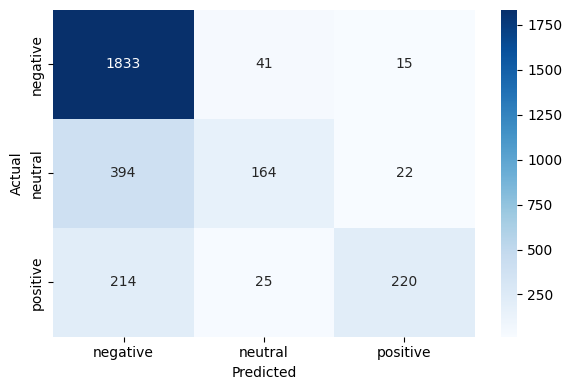


📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.97      0.85      1889
     neutral       0.71      0.28      0.40       580
    positive       0.86      0.48      0.61       459

    accuracy                           0.76      2928
   macro avg       0.77      0.58      0.62      2928
weighted avg       0.76      0.76      0.72      2928



In [60]:
# Make predictions with test data
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n✅ Accuracy: {accuracy:.2f}")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_ if hasattr(model, "classes_") else sorted(set(y_test)),
            yticklabels=model.classes_ if hasattr(model, "classes_") else sorted(set(y_test)))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# 9.0 - Compare the Models (Logistic Regression, Random Forest, Support Vector Machine)


🔍 Evaluating model: Logistic Regression

✅ Accuracy: 0.84

✅ Accuracy: 0.84


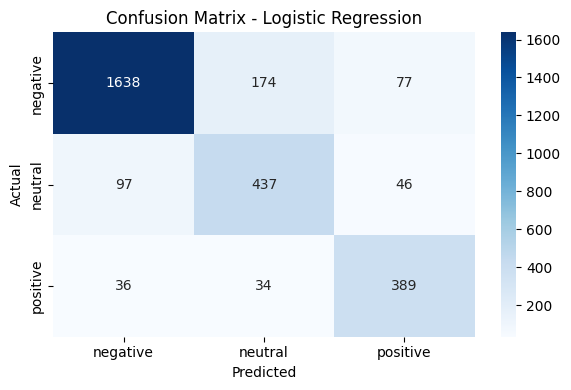


📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.87      0.90      1889
     neutral       0.68      0.75      0.71       580
    positive       0.76      0.85      0.80       459

    accuracy                           0.84      2928
   macro avg       0.79      0.82      0.80      2928
weighted avg       0.85      0.84      0.84      2928


🔍 Evaluating model: Support Vector Machine

✅ Accuracy: 0.87

✅ Accuracy: 0.87


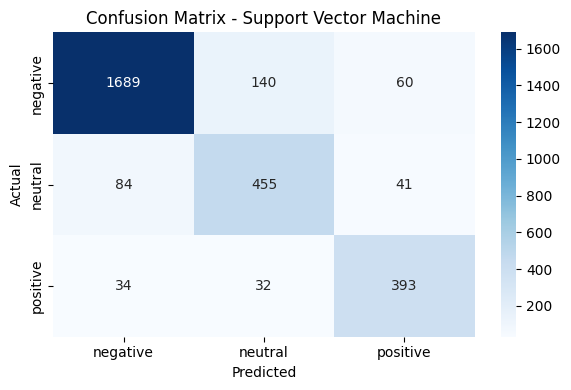


📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.93      0.89      0.91      1889
     neutral       0.73      0.78      0.75       580
    positive       0.80      0.86      0.82       459

    accuracy                           0.87      2928
   macro avg       0.82      0.84      0.83      2928
weighted avg       0.87      0.87      0.87      2928


🔍 Evaluating model: Random Forest

✅ Accuracy: 0.94

✅ Accuracy: 0.94


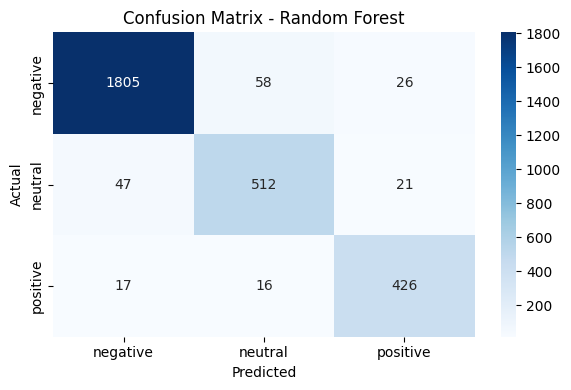


📋 Classification Report:
              precision    recall  f1-score   support

    negative       0.97      0.96      0.96      1889
     neutral       0.87      0.88      0.88       580
    positive       0.90      0.93      0.91       459

    accuracy                           0.94      2928
   macro avg       0.91      0.92      0.92      2928
weighted avg       0.94      0.94      0.94      2928



In [61]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Support Vector Machine": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\n🔍 Evaluating model: {name}")
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Accuracy: {acc:.2f}")

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_ if hasattr(model, "classes_") else sorted(set(y_test)),
                yticklabels=model.classes_ if hasattr(model, "classes_") else sorted(set(y_test)))
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred))


# 10.0 - Generate a Word Cloud

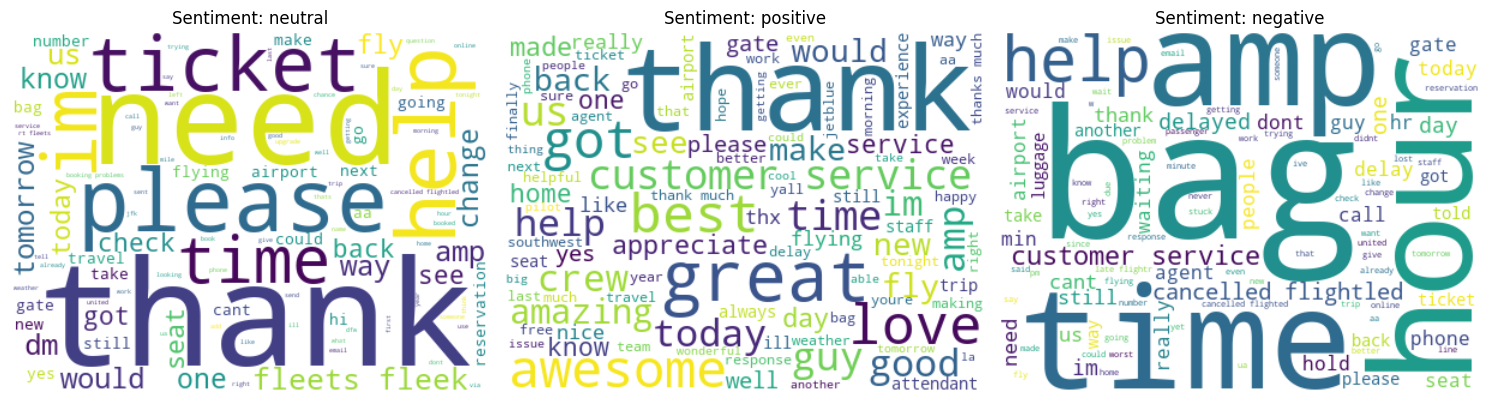

In [62]:
# Simplified version - create wordclouds by sentiment
from wordcloud import WordCloud
import matplotlib.pyplot as plt

custom_stopwords = set(['flight', 'flights', 'airline', 'airlines', 'get', 'u', 'plane'])

# Get unique sentiments
sentiments = df_no_stopwords['airline_sentiment'].unique()

# Create subplots
fig, axes = plt.subplots(1, len(sentiments), figsize=(15, 5))

for i, sentiment in enumerate(sentiments):
    # Filter texts by sentiment
    texts = df_no_stopwords[df_no_stopwords['airline_sentiment'] == sentiment]['clean_text']
    
    # Combine all texts
    combined_text = ' '.join(texts.astype(str))
    
    # Create wordcloud
    wordcloud = WordCloud(
        width=400, 
        height=300,
        stopwords=custom_stopwords,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(combined_text)
    
    # Plot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Sentiment: {sentiment}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()